## ML-Model: Random Forest

# import libraries

In [11]:
# import necessary libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 

#sklearn

from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import f1_score, fbeta_score
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, balanced_accuracy_score

# import custom functions

from custom_functions import get_data_summary, our_metrics, eval_metrics, evaluate_model


import warnings
warnings.filterwarnings('ignore')
RSEED = 42

In [12]:
#codeline for non-tree models

# X_train_minmax = pd.read_csv('data/X_train_minmax.csv', delimiter=',')
# X_test_minmax = pd.read_csv('data/X_test_minmax.csv', delimiter=',')
# X_train_std = pd.read_csv('data/X_train_std.csv', delimiter=',')
# X_test_std = pd.read_csv('data/X_test_std.csv', delimiter=',')
# y_train = pd.read_csv('data/y_train.csv', delimiter=',')
# y_test = pd.read_csv('data/y_test.csv', delimiter=',')

# Import train-train-split for trees

In [13]:
# Import train-train-split for trees
X_train_tree_small = pd.read_csv('data/X_train_tree_small.csv', delimiter=',')
X_train_tree_large = pd.read_csv('data/X_train_tree_large.csv', delimiter=',')
y_train_tree_small = pd.read_csv('data/y_train_tree_small.csv', delimiter=',')
y_train_tree_large = pd.read_csv('data/y_train_tree_large.csv', delimiter=',')

In [14]:
#reshape y into 2D-array

y_train_tree_small = np.ravel(y_train_tree_small).reshape(-1, 1) 
y_train_tree_large = np.ravel(y_train_tree_large).reshape(-1, 1) 

# Import entire data set: test and train data, target

In [15]:
# X_train_tree = pd.read_csv('data/X_train_tree.csv', delimiter=',')
# X_test_tree = pd.read_csv('data/X_test_tree.csv', delimiter=',')
# y_train_tree = pd.read_csv('data/y_train_tree.csv', delimiter=',')
# y_test_tree = pd.read_csv('data/y_test_tree.csv', delimiter=',')

In [16]:
#reshape y into array

# y_test_tree = np.ravel(y_test_tree)
# y_train_tree = np.ravel(y_train_tree)

# Instantiating and training model with default hyperparams

In [17]:
# Create the model with 100 trees
random_forest_default = RandomForestClassifier(n_estimators=100, 
                               random_state=RSEED, 
                               max_features = 'sqrt',
                               n_jobs=-1, verbose = 1)

# Fit on small subset of training data
random_forest_default.fit(X_train_tree_small, y_train_tree_small)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   13.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   34.7s finished


RandomForestClassifier(n_jobs=-1, random_state=42, verbose=1)

In [18]:
# number of nodes and depths of trees in the forest:

n_nodes = []
max_depths = []

for ind_tree in random_forest_default.estimators_:
    n_nodes.append(ind_tree.tree_.node_count)
    max_depths.append(ind_tree.tree_.max_depth)
    
print(f'Average number of nodes {int(np.mean(n_nodes))}')
print(f'Average maximum depth {int(np.mean(max_depths))}')

Average number of nodes 216250
Average maximum depth 61


# Default hyperpaprams model performance

In [19]:
# predicting target and prediction probabilities with small data subset:

rf_y_pred_train_small = random_forest_default.predict(X_train_tree_small)
rf_y_probs_train_small = random_forest_default.predict_proba(X_train_tree_small)[:, 1]

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    3.3s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    8.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    3.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    8.4s finished


In [20]:
# accuracy matrix: predicted target and true target (small subset of training data)

our_metrics(y_train_tree_small, rf_y_pred_train)

NameError: name 'rf_y_pred_train' is not defined

In [21]:
# predicting target and prediction probabilities with large data subset:

rf_y_pred_train_large = random_forest_default.predict(X_train_tree_large)
rf_y_probs_train_large = random_forest_default.predict_proba(X_train_tree_large)[:, 1]

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    7.5s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   19.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    7.3s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   19.0s finished


In [ ]:
# accuracy matrix: predicted target and true target (large subset of training data)

our_metrics(y_train_tree_large, rf_y_pred_train_large)

In [ ]:
cm = confusion_matrix(y_train_tree_small, rf_y_pred_train)
plot_confusion_matrix(cm, classes = ['Non-Fraud', 'Fraud'],
                     title = 'Random Forest Default Confusion Matrix')

# RandomizedSearch CV for best Hyperparams for best Fbeta-Score

In [ ]:
# making own scorer to use in random search cross validation
# set beta = 2

fbeta_scorer = make_scorer(fbeta_score, beta=2)

In [ ]:
# Hyperparameter grid
param_grid = {
    'n_estimators': np.linspace(10, 200).astype(int),
    'max_depth': [None] + list(np.linspace(3, 20).astype(int)),
    'max_features': ['auto', 'sqrt', None] + list(np.arange(0.5, 1, 0.1)),
    'max_leaf_nodes': [None] + list(np.linspace(10, 50, 500).astype(int)),
    'min_samples_split': [2, 5, 10],
    'bootstrap': [True, False]
}

# Estimator for use in random search
estimator = RandomForestClassifier(random_state = RSEED)

# Create the random search model
rs = RandomizedSearchCV(estimator, param_grid, n_jobs = -1, 
                        scoring = 'roc_auc', cv = 3, 
                        n_iter = 10, verbose = 5, random_state=RSEED)

# cv = cross validation

# Fit 
rs.fit(train, train_labels)

In [ ]:
# # Best score
# print('Best score:', round(rs_beta.best_score_,2))

# # Best parameters
# print('Best parameters:', rs_beta.best_params_)

In [ ]:
# # Assigning the fitted SGDClassifier model with best parameter combination to a new variable sgd_best
# best_model_beta = rs_beta.best_estimator_

In [ ]:
# # checking results on test set with threshold <= 0.4
# class_metrics_var_threshold(best_model_beta, X_test_preprocessed, y_test, threshold=0.5)

Model Metrics and Normalized Confusion Matrix
_____________________
_____________________
Accuracy: 0.9222
_____________________
F1-score: 0.2546
_____________________
Fbeta_score with beta=1.5: 0.2127
_____________________
Fbeta_score with beta=2: 0.1948
_____________________
Fbeta_score with beta=3: 0.1806
_____________________
Recall 0.1684
_____________________
Specificity 0.9868


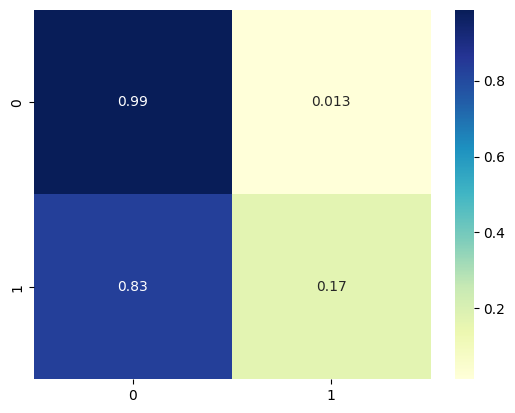

In [22]:
our_metrics(y_train_tree_large, rf_y_pred_train_large, normalize=True)